# Ethereum Gas Price History Analysis
## Pre vs Post Dencun Upgrade: A Statistical Deep Dive

This notebook analyzes the structural break in Ethereum gas prices caused by the **Dencun upgrade on March 13, 2024**.

**Key Questions:**
1. How much did gas prices change after Dencun?
2. Did volatility decrease?
3. What happened to extreme price spikes?
4. What does this mean for predictive models?

## Table of Contents

### Part 1: Exploratory Data Analysis
1. Setup & Constants
2. Load Data
3. Time Series Visualization
4. Distribution Comparison
5. Summary Statistics
6. Detailed Statistical Analysis
7. Statistical Significance Testing
8. Master Dashboard
9. Seasonality Analysis

### Part 2: Predictive Modeling
10. Target Engineering (3 Time Horizons)
11. Feature Engineering & Definition
12. Train/Test Split
13. Baseline Models (Persistence)
14. Ridge Regression - Naive Features
15. Ridge Regression - Smart Features
16. Hyperparameter Tuning (Alpha Sweep)
17. Diagnostic Analysis
18. Additional Diagnostic Tests

### Part 3: Results & Conclusions
19. Model Comparison Table
20. Visualization Dashboard
21. Final Conclusions & Recommendations

---

# Part 1: Exploratory Data Analysis

## Objective
Understand the statistical properties of Ethereum gas prices before and after the Dencun upgrade (March 13, 2024).

**Key Questions:**
- Did mean prices change?
- Did volatility decrease?
- Are there temporal patterns (weekends, hours)?
- How significant are the changes?

---

## 1. Setup & Constants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Constants
DENCUN_DATE = pd.Timestamp('2024-03-13', tz='UTC')
DATA_FOLDER = r'C:\Users\maxgn\Digital Assets Trading\Ethereum-ML\Gas Analysis'

print("✓ Setup complete")

✓ Setup complete


## 2. Load Data

In [2]:
os.chdir(DATA_FOLDER)

df = pd.read_csv('gas_ML_data.csv')
df['block_timestamp'] = pd.to_datetime(df['block_timestamp'])
df = df.sort_values('block_number').reset_index(drop=True)

df_pre = df[df['block_timestamp'] < DENCUN_DATE].copy()
df_post = df[df['block_timestamp'] >= DENCUN_DATE].copy()

print(f"Total blocks: {len(df):,}")
print(f"Pre-Dencun:   {len(df_pre):,} blocks")
print(f"Post-Dencun:  {len(df_post):,} blocks")

Total blocks: 2,123,909
Pre-Dencun:   1,277,849 blocks
Post-Dencun:  846,060 blocks


## 3. Time Series Visualization

Let's see the overall trend and identify the Dencun effect visually.

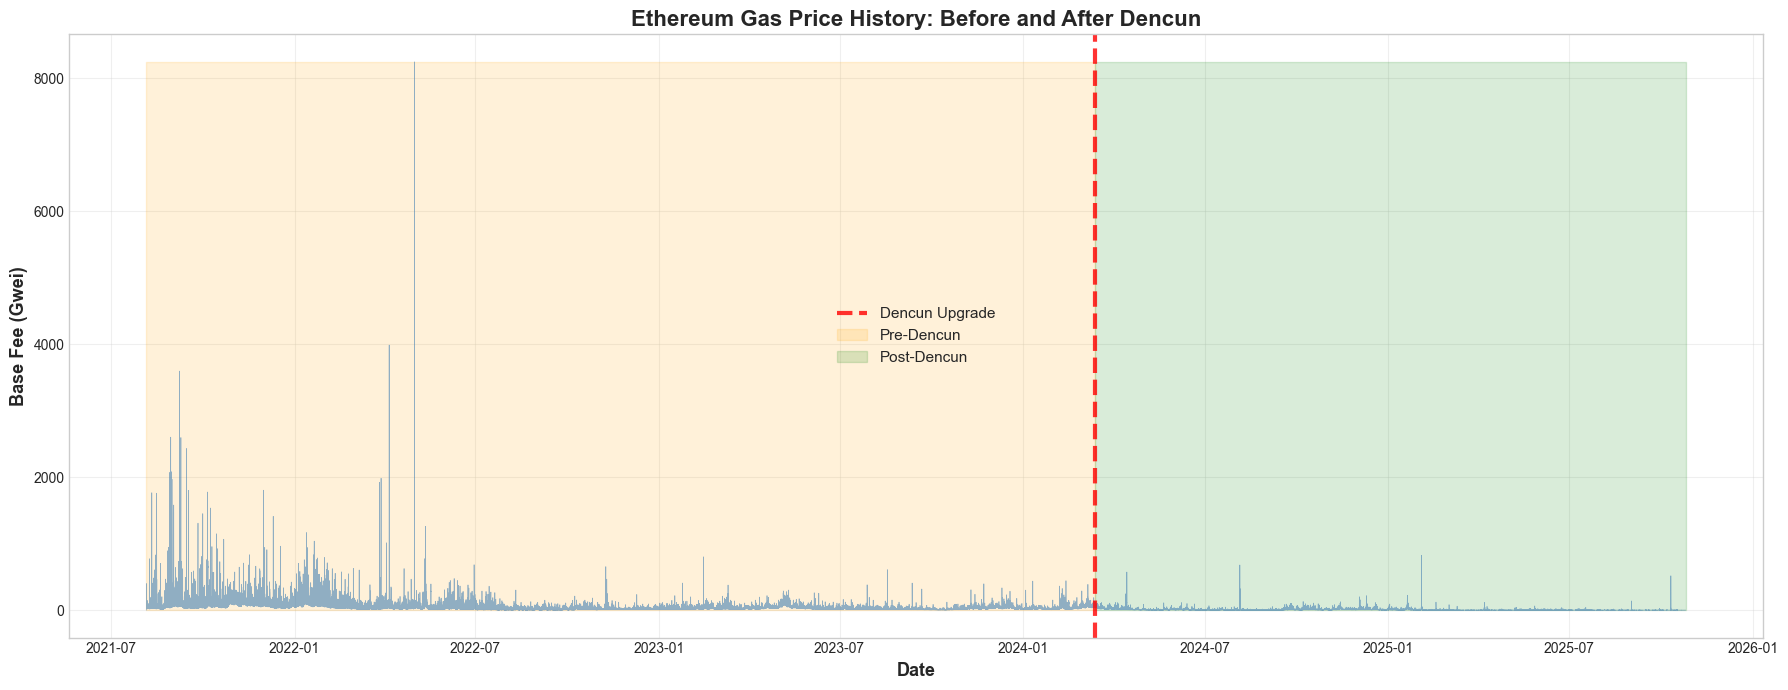

In [3]:
fig, ax = plt.subplots(figsize=(18, 7))

ax.plot(df['block_timestamp'], df['base_fee_per_gas'] / 1e9, 
        color='steelblue', alpha=0.6, linewidth=0.5)
ax.axvline(DENCUN_DATE, color='red', linestyle='--', linewidth=3, 
           label='Dencun Upgrade', alpha=0.8)
ax.fill_betweenx([0, df['base_fee_per_gas'].max() / 1e9], 
                  df['block_timestamp'].min(), DENCUN_DATE, 
                  alpha=0.15, color='orange', label='Pre-Dencun')
ax.fill_betweenx([0, df['base_fee_per_gas'].max() / 1e9], 
                  DENCUN_DATE, df['block_timestamp'].max(), 
                  alpha=0.15, color='green', label='Post-Dencun')

ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Base Fee (Gwei)', fontsize=13, fontweight='bold')
ax.set_title('Ethereum Gas Price History: Before and After Dencun', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Distribution Comparison

How did the distribution of gas prices change?

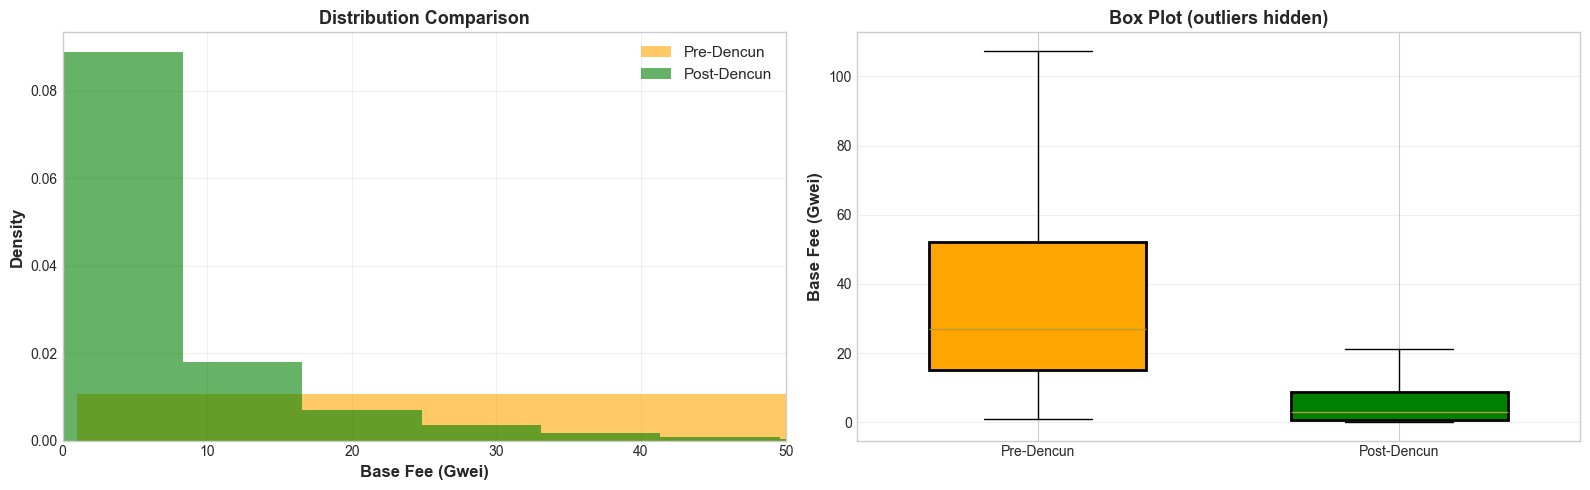

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
axes[0].hist(df_pre['base_fee_per_gas'] / 1e9, bins=100, alpha=0.6, 
             color='orange', label='Pre-Dencun', density=True)
axes[0].hist(df_post['base_fee_per_gas'] / 1e9, bins=100, alpha=0.6, 
             color='green', label='Post-Dencun', density=True)
axes[0].set_xlabel('Base Fee (Gwei)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Density', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution Comparison', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].set_xlim(0, 50)
axes[0].grid(alpha=0.3)

# Box plot
data_box = [df_pre['base_fee_per_gas'] / 1e9, df_post['base_fee_per_gas'] / 1e9]
bp = axes[1].boxplot(data_box, labels=['Pre-Dencun', 'Post-Dencun'],
                      patch_artist=True, showfliers=False, widths=0.6)
bp['boxes'][0].set_facecolor('orange')
bp['boxes'][1].set_facecolor('green')
for box in bp['boxes']:
    box.set_linewidth(2)
    box.set_edgecolor('black')

axes[1].set_ylabel('Base Fee (Gwei)', fontsize=12, fontweight='bold')
axes[1].set_title('Box Plot (outliers hidden)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Summary Statistics

Basic summary statistics for both periods.

In [5]:
print("="*70)
print(" "*20 + "BASIC STATISTICS")
print("="*70)

print("\nPRE-DENCUN:")
print(f"  Mean:   {df_pre['base_fee_per_gas'].mean() / 1e9:.2f} Gwei")
print(f"  Median: {df_pre['base_fee_per_gas'].median() / 1e9:.2f} Gwei")
print(f"  Std:    {df_pre['base_fee_per_gas'].std() / 1e9:.2f} Gwei")
print(f"  Max:    {df_pre['base_fee_per_gas'].max() / 1e9:.2f} Gwei")

print("\nPOST-DENCUN:")
print(f"  Mean:   {df_post['base_fee_per_gas'].mean() / 1e9:.2f} Gwei")
print(f"  Median: {df_post['base_fee_per_gas'].median() / 1e9:.2f} Gwei")
print(f"  Std:    {df_post['base_fee_per_gas'].std() / 1e9:.2f} Gwei")
print(f"  Max:    {df_post['base_fee_per_gas'].max() / 1e9:.2f} Gwei")

mean_change = ((df_post['base_fee_per_gas'].mean() - df_pre['base_fee_per_gas'].mean()) / 
               df_pre['base_fee_per_gas'].mean() * 100)
std_change = ((df_post['base_fee_per_gas'].std() - df_pre['base_fee_per_gas'].std()) / 
              df_pre['base_fee_per_gas'].std() * 100)

print("\n💡 CHANGES:")
print(f"  Mean:   {mean_change:+.1f}%")
print(f"  Std:    {std_change:+.1f}%")

                    BASIC STATISTICS

PRE-DENCUN:
  Mean:   42.81 Gwei
  Median: 26.95 Gwei
  Std:    77.83 Gwei
  Max:    8247.59 Gwei

POST-DENCUN:
  Mean:   6.98 Gwei
  Median: 2.84 Gwei
  Std:    12.04 Gwei
  Max:    825.52 Gwei

💡 CHANGES:
  Mean:   -83.7%
  Std:    -84.5%


## 6. Detailed Statistical Analysis

Computing comprehensive statistics including percentiles, skewness, and kurtosis.

In [6]:
def compute_stats(series, name):
    """Compute comprehensive statistics"""
    return {
        'Period': name,
        'Count': len(series),
        'Mean (Gwei)': series.mean() / 1e9,
        'Median (Gwei)': series.median() / 1e9,
        'Std Dev (Gwei)': series.std() / 1e9,
        'Min (Gwei)': series.min() / 1e9,
        'Max (Gwei)': series.max() / 1e9,
        'P25 (Gwei)': series.quantile(0.25) / 1e9,
        'P75 (Gwei)': series.quantile(0.75) / 1e9,
        'P90 (Gwei)': series.quantile(0.90) / 1e9,
        'P95 (Gwei)': series.quantile(0.95) / 1e9,
        'P99 (Gwei)': series.quantile(0.99) / 1e9,
        'Skewness': stats.skew(series.dropna()),
        'Kurtosis': stats.kurtosis(series.dropna()),
        'CV (%)': (series.std() / series.mean()) * 100
    }

stats_pre = compute_stats(df_pre['base_fee_per_gas'], 'Pre-Dencun')
stats_post = compute_stats(df_post['base_fee_per_gas'], 'Post-Dencun')
df_stats = pd.DataFrame([stats_pre, stats_post])

df_stats

,Period,Count,Mean (Gwei),Median (Gwei),Std Dev (Gwei),Min (Gwei),Max (Gwei),P25 (Gwei),P75 (Gwei),P90 (Gwei),P95 (Gwei),P99 (Gwei),Skewness,Kurtosis,CV (%)
0,Pre-Dencun,1277849,42.812077,26.948202,77.833229,1.000000,8247.590623,15.065812,51.983821,95.387430,126.668606,199.563055,50.185858,3840.668217,181.802038
1,Post-Dencun,846060,6.983514,2.839922,12.041139,0.063513,825.516735,0.697043,8.884264,18.510881,26.910460,48.409104,10.534519,323.527043,172.422354


### 6a. Metrics Comparison Chart

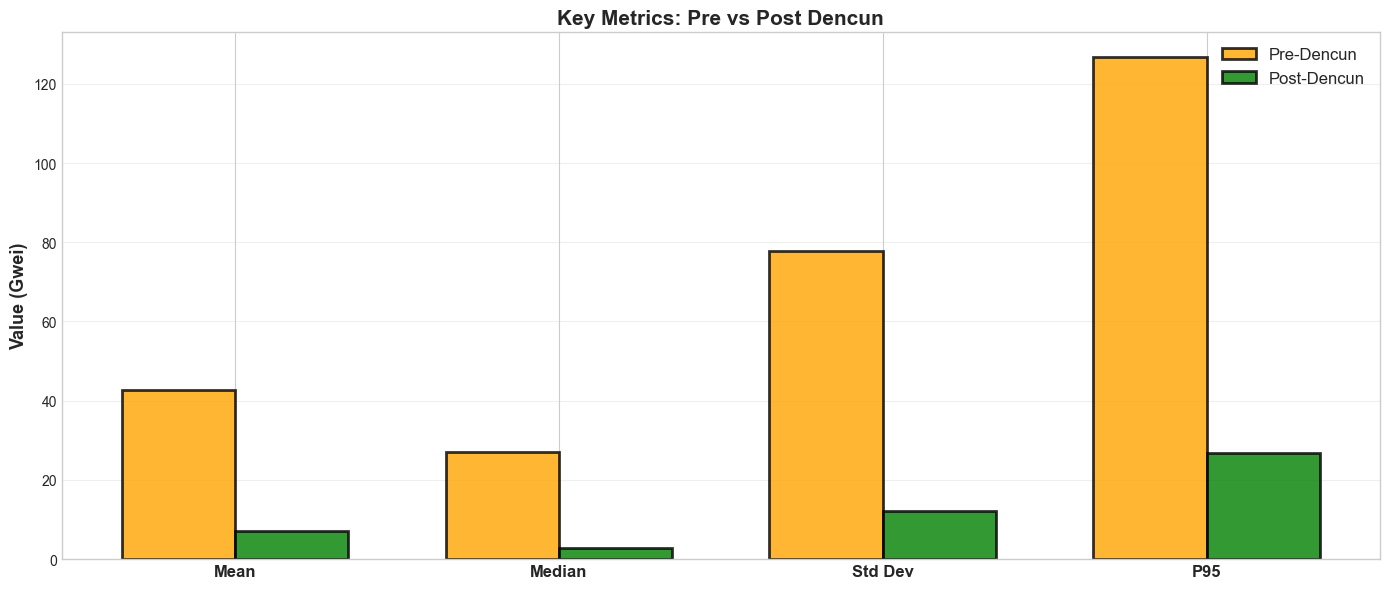

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

metrics = ['Mean', 'Median', 'Std Dev', 'P95']
pre_vals = [stats_pre['Mean (Gwei)'], stats_pre['Median (Gwei)'], 
            stats_pre['Std Dev (Gwei)'], stats_pre['P95 (Gwei)']]
post_vals = [stats_post['Mean (Gwei)'], stats_post['Median (Gwei)'], 
             stats_post['Std Dev (Gwei)'], stats_post['P95 (Gwei)']]

x = np.arange(len(metrics))
width = 0.35

ax.bar(x - width/2, pre_vals, width, label='Pre-Dencun', 
       color='orange', alpha=0.8, edgecolor='black', linewidth=2)
ax.bar(x + width/2, post_vals, width, label='Post-Dencun', 
       color='green', alpha=0.8, edgecolor='black', linewidth=2)

ax.set_ylabel('Value (Gwei)', fontsize=13, fontweight='bold')
ax.set_title('Key Metrics: Pre vs Post Dencun', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 6b. Volatility Analysis

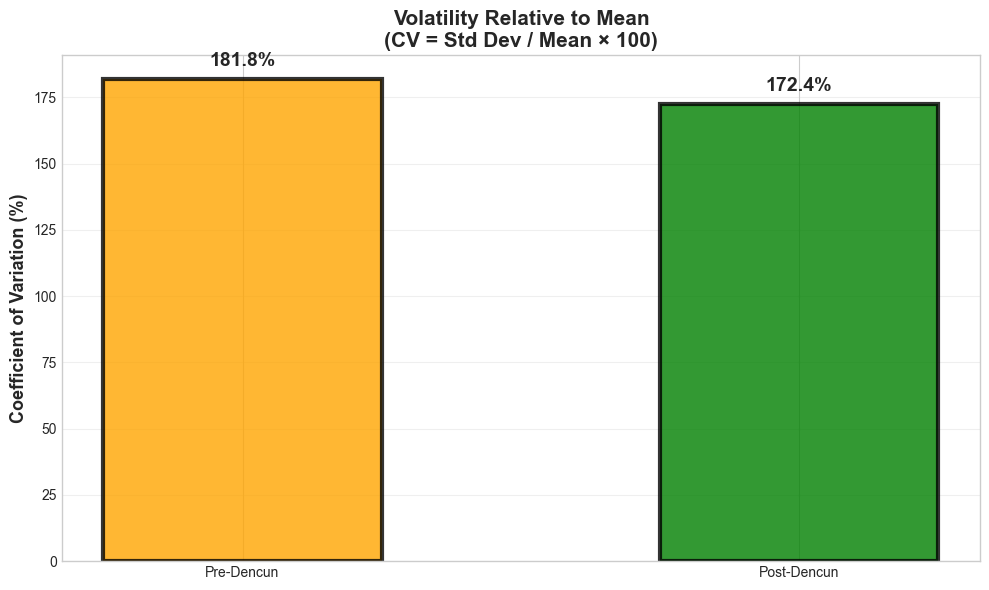

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

cv_data = [stats_pre['CV (%)'], stats_post['CV (%)']]
bars = ax.bar(['Pre-Dencun', 'Post-Dencun'], cv_data, 
              color=['orange', 'green'], alpha=0.8, 
              edgecolor='black', linewidth=3, width=0.5)

ax.set_ylabel('Coefficient of Variation (%)', fontsize=13, fontweight='bold')
ax.set_title('Volatility Relative to Mean\n(CV = Std Dev / Mean × 100)', 
             fontsize=15, fontweight='bold')
ax.grid(alpha=0.3, axis='y')

for bar, val in zip(bars, cv_data):
    ax.text(bar.get_x() + bar.get_width()/2, val + 5, 
            f'{val:.1f}%', ha='center', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 6c. Percentile Analysis

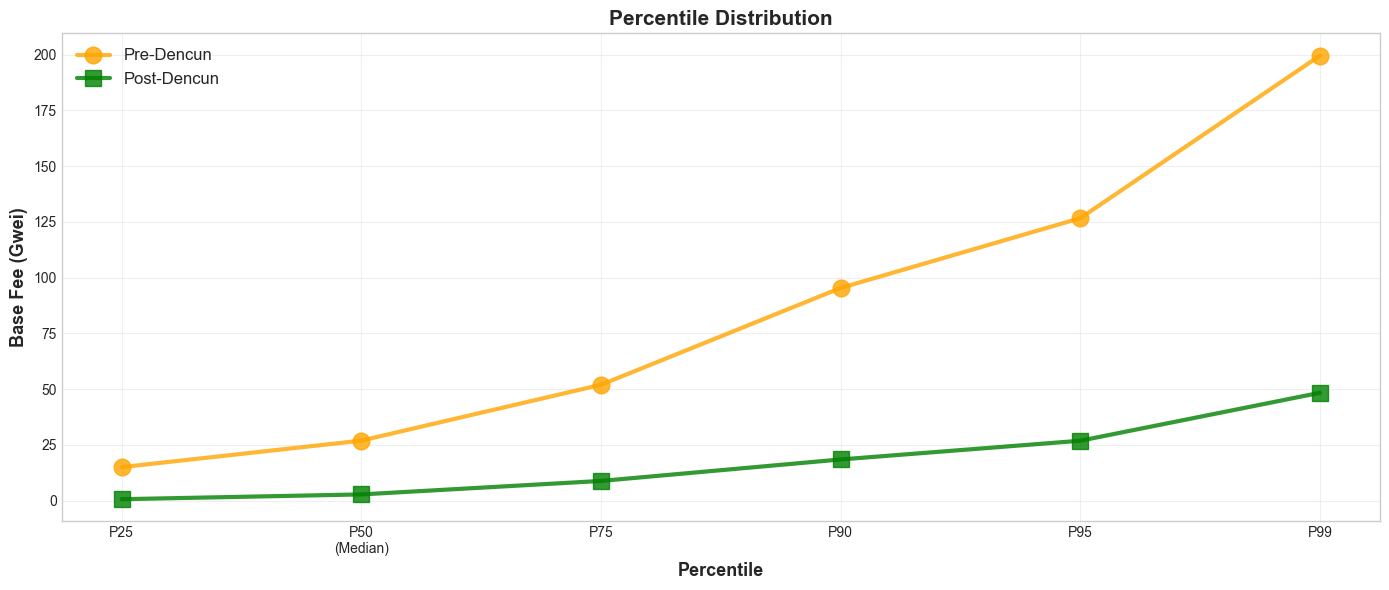

In [9]:
fig, ax = plt.subplots(figsize=(14, 6))

percentiles = ['P25', 'P50\n(Median)', 'P75', 'P90', 'P95', 'P99']
pre_pcts = [stats_pre['P25 (Gwei)'], stats_pre['Median (Gwei)'], 
            stats_pre['P75 (Gwei)'], stats_pre['P90 (Gwei)'],
            stats_pre['P95 (Gwei)'], stats_pre['P99 (Gwei)']]
post_pcts = [stats_post['P25 (Gwei)'], stats_post['Median (Gwei)'], 
             stats_post['P75 (Gwei)'], stats_post['P90 (Gwei)'],
             stats_post['P95 (Gwei)'], stats_post['P99 (Gwei)']]

ax.plot(percentiles, pre_pcts, 'o-', color='orange', linewidth=3, 
        markersize=12, label='Pre-Dencun', alpha=0.8)
ax.plot(percentiles, post_pcts, 's-', color='green', linewidth=3, 
        markersize=12, label='Post-Dencun', alpha=0.8)

ax.set_xlabel('Percentile', fontsize=13, fontweight='bold')
ax.set_ylabel('Base Fee (Gwei)', fontsize=13, fontweight='bold')
ax.set_title('Percentile Distribution', fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Statistical Significance Test

In [10]:
t_stat, p_value = stats.ttest_ind(
    df_pre['base_fee_per_gas'].dropna(), 
    df_post['base_fee_per_gas'].dropna()
)

print("T-Test Results:")
print(f"  T-statistic: {t_stat:.2f}")
print(f"  P-value:     {p_value:.2e}")

if p_value < 0.001:
    print(f"\n✓ HIGHLY SIGNIFICANT (p < 0.001)")
    print(f"  The difference is NOT due to random chance!")

T-Test Results:
  T-statistic: 420.10
  P-value:     0.00e+00

✓ HIGHLY SIGNIFICANT (p < 0.001)
  The difference is NOT due to random chance!


## 8. Master Dashboard

All visualizations combined.

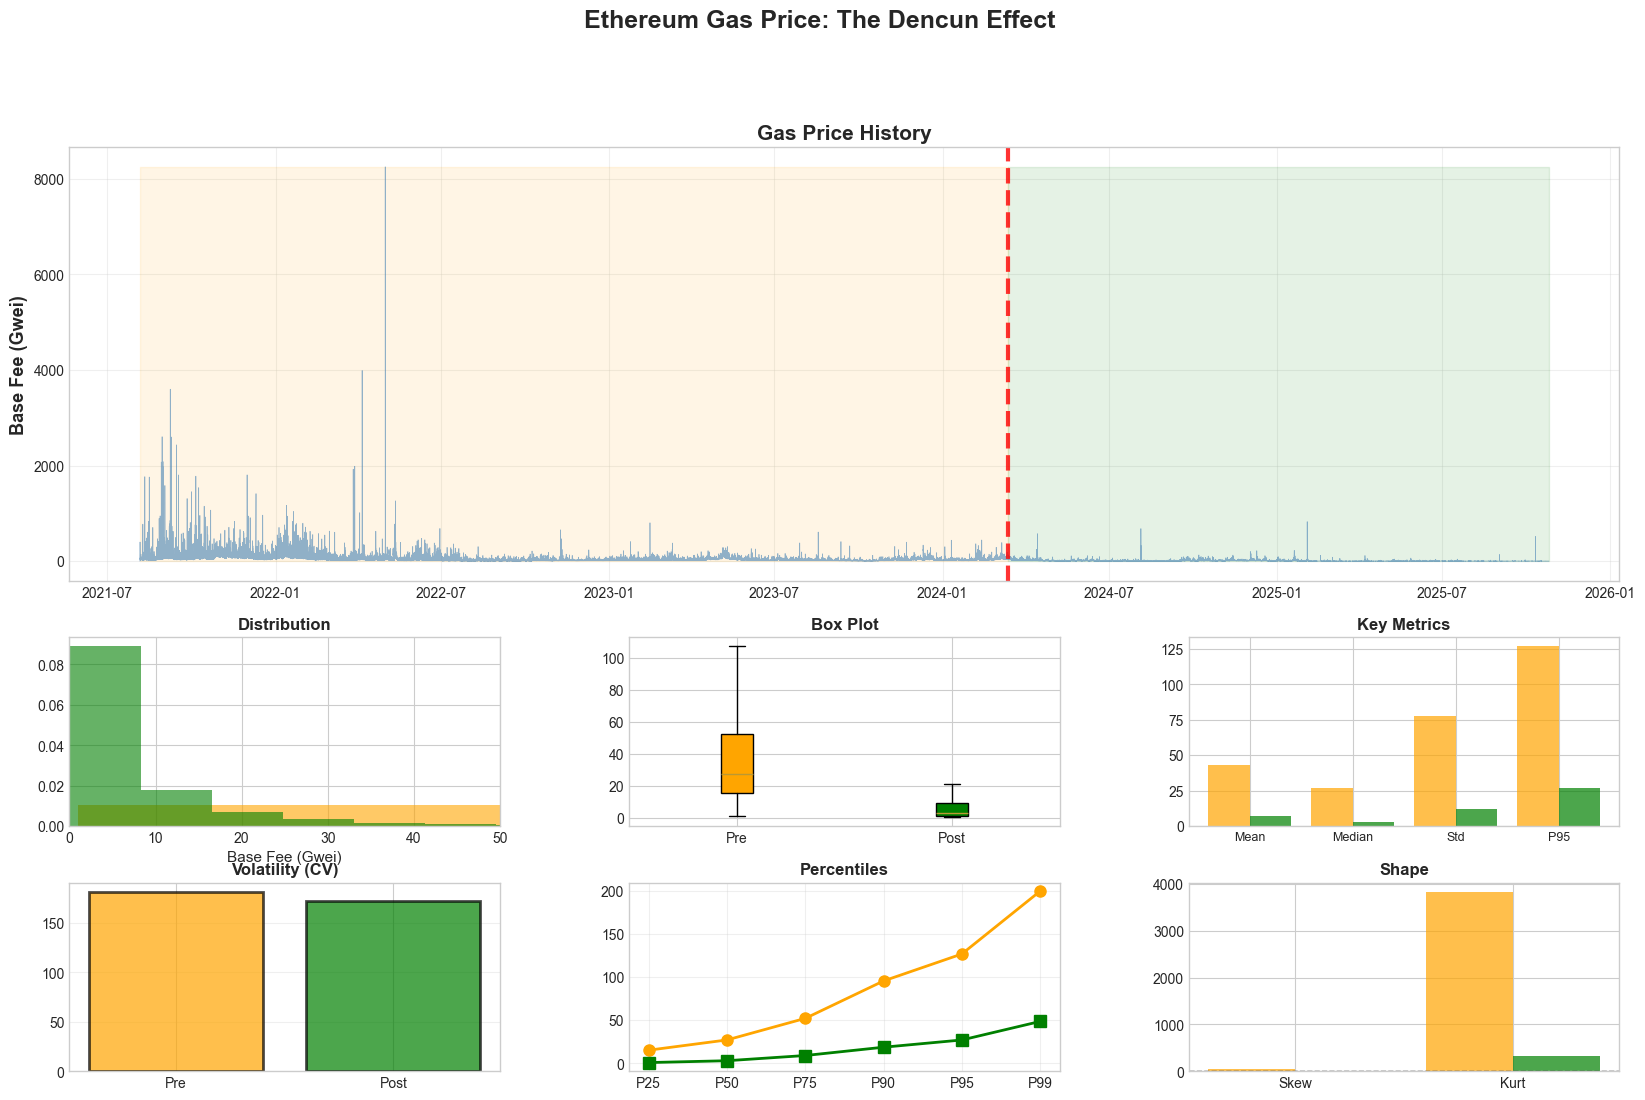

In [11]:
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

fig.suptitle('Ethereum Gas Price: The Dencun Effect', 
             fontsize=18, fontweight='bold', y=0.995)

# Time series (large, top)
ax1 = fig.add_subplot(gs[0:2, :])
ax1.plot(df['block_timestamp'], df['base_fee_per_gas'] / 1e9, 
         color='steelblue', alpha=0.6, linewidth=0.5)
ax1.axvline(DENCUN_DATE, color='red', linestyle='--', linewidth=3, alpha=0.8)
ax1.fill_betweenx([0, df['base_fee_per_gas'].max() / 1e9], 
                   df['block_timestamp'].min(), DENCUN_DATE, alpha=0.1, color='orange')
ax1.fill_betweenx([0, df['base_fee_per_gas'].max() / 1e9], 
                   DENCUN_DATE, df['block_timestamp'].max(), alpha=0.1, color='green')
ax1.set_ylabel('Base Fee (Gwei)', fontsize=13, fontweight='bold')
ax1.set_title('Gas Price History', fontsize=15, fontweight='bold')
ax1.grid(alpha=0.3)

# Histogram
ax2 = fig.add_subplot(gs[2, 0])
ax2.hist(df_pre['base_fee_per_gas'] / 1e9, bins=100, alpha=0.6, 
         color='orange', density=True)
ax2.hist(df_post['base_fee_per_gas'] / 1e9, bins=100, alpha=0.6, 
         color='green', density=True)
ax2.set_xlabel('Base Fee (Gwei)', fontsize=11)
ax2.set_title('Distribution', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 50)

# Box plot
ax3 = fig.add_subplot(gs[2, 1])
bp = ax3.boxplot([df_pre['base_fee_per_gas'] / 1e9, df_post['base_fee_per_gas'] / 1e9],
                  labels=['Pre', 'Post'], patch_artist=True, showfliers=False)
bp['boxes'][0].set_facecolor('orange')
bp['boxes'][1].set_facecolor('green')
ax3.set_title('Box Plot', fontsize=12, fontweight='bold')

# Metrics bars
ax4 = fig.add_subplot(gs[2, 2])
metrics = ['Mean', 'Median', 'Std', 'P95']
pre_v = [stats_pre['Mean (Gwei)'], stats_pre['Median (Gwei)'], 
         stats_pre['Std Dev (Gwei)'], stats_pre['P95 (Gwei)']]
post_v = [stats_post['Mean (Gwei)'], stats_post['Median (Gwei)'], 
          stats_post['Std Dev (Gwei)'], stats_post['P95 (Gwei)']]
x = np.arange(len(metrics))
ax4.bar(x - 0.2, pre_v, 0.4, color='orange', alpha=0.7)
ax4.bar(x + 0.2, post_v, 0.4, color='green', alpha=0.7)
ax4.set_xticks(x)
ax4.set_xticklabels(metrics, fontsize=9)
ax4.set_title('Key Metrics', fontsize=12, fontweight='bold')

# CV
ax5 = fig.add_subplot(gs[3, 0])
ax5.bar(['Pre', 'Post'], [stats_pre['CV (%)'], stats_post['CV (%)']], 
        color=['orange', 'green'], alpha=0.7, edgecolor='black', linewidth=2)
ax5.set_title('Volatility (CV)', fontsize=12, fontweight='bold')
ax5.grid(alpha=0.3, axis='y')

# Percentiles
ax6 = fig.add_subplot(gs[3, 1])
pcts = ['P25', 'P50', 'P75', 'P90', 'P95', 'P99']
pre_p = [stats_pre['P25 (Gwei)'], stats_pre['Median (Gwei)'], 
         stats_pre['P75 (Gwei)'], stats_pre['P90 (Gwei)'],
         stats_pre['P95 (Gwei)'], stats_pre['P99 (Gwei)']]
post_p = [stats_post['P25 (Gwei)'], stats_post['Median (Gwei)'], 
          stats_post['P75 (Gwei)'], stats_post['P90 (Gwei)'],
          stats_post['P95 (Gwei)'], stats_post['P99 (Gwei)']]
ax6.plot(pcts, pre_p, 'o-', color='orange', linewidth=2, markersize=8)
ax6.plot(pcts, post_p, 's-', color='green', linewidth=2, markersize=8)
ax6.set_title('Percentiles', fontsize=12, fontweight='bold')
ax6.grid(alpha=0.3)

# Shape
ax7 = fig.add_subplot(gs[3, 2])
x = np.arange(2)
ax7.bar(x - 0.2, [stats_pre['Skewness'], stats_pre['Kurtosis']], 0.4, 
        color='orange', alpha=0.7)
ax7.bar(x + 0.2, [stats_post['Skewness'], stats_post['Kurtosis']], 0.4, 
        color='green', alpha=0.7)
ax7.set_xticks(x)
ax7.set_xticklabels(['Skew', 'Kurt'], fontsize=10)
ax7.set_title('Shape', fontsize=12, fontweight='bold')
ax7.axhline(0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig('gas_analysis_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Seasonality Analysis: Do Time Patterns Matter?

Before building predictive models, we need to understand if gas prices exhibit systematic patterns across time dimensions.

**What we're testing:**
- Day of week effects (weekdays vs weekends)
- Regional hour patterns (US/EU/Asia peaks)
- Statistical significance (are patterns real or noise?)

**Why this matters for modeling:**
If time patterns exist but are already reflected in the current price level, adding them as features will add noise rather than signal (multicollinearity).

This analysis will inform our feature engineering decisions.

---

### 9a. Day of Week & Weekend Analysis

In [12]:
print("="*90)
print(" "*20 + "GAS PRICE SEASONALITY ANALYSIS")
print("="*90)

# Split into pre and post Dencun
df_pre = df[df['block_timestamp'] < DENCUN_DATE].copy()
df_post = df[df['block_timestamp'] >= DENCUN_DATE].copy()

print(f"\nPre-Dencun:  {len(df_pre):,} blocks")
print(f"Post-Dencun: {len(df_post):,} blocks")

# Analysis function
def analyze_seasonality(df_pre, df_post, group_col, group_name):
    """Compare gas prices across a time dimension"""
    
    # Group and calculate stats
    pre_grouped = df_pre.groupby(group_col)['base_fee_per_gas'].agg(['mean', 'median', 'std', 'count'])
    post_grouped = df_post.groupby(group_col)['base_fee_per_gas'].agg(['mean', 'median', 'std', 'count'])
    
    # Convert to Gwei
    pre_grouped[['mean', 'median', 'std']] = pre_grouped[['mean', 'median', 'std']] / 1e9
    post_grouped[['mean', 'median', 'std']] = post_grouped[['mean', 'median', 'std']] / 1e9
    
    print(f"\n{'='*90}")
    print(f" {group_name}")
    print(f"{'='*90}")
    
    # Merge for comparison
    comparison = pd.DataFrame({
        'Pre_Mean': pre_grouped['mean'],
        'Post_Mean': post_grouped['mean'],
        'Pre_Std': pre_grouped['std'],
        'Post_Std': post_grouped['std'],
        'Pre_Count': pre_grouped['count'],
        'Post_Count': post_grouped['count']
    })
    
    # Calculate changes
    comparison['Mean_Change_%'] = ((comparison['Post_Mean'] - comparison['Pre_Mean']) / comparison['Pre_Mean'] * 100)
    comparison['Std_Change_%'] = ((comparison['Post_Std'] - comparison['Pre_Std']) / comparison['Pre_Std'] * 100)
    
    print(f"\n{comparison.to_string()}")
    
    # Statistical test
    if len(pre_grouped) > 1:
        groups_pre = [df_pre[df_pre[group_col] == g]['base_fee_per_gas'].dropna() for g in pre_grouped.index]
        f_stat_pre, p_val_pre = stats.f_oneway(*groups_pre)
        
        groups_post = [df_post[df_post[group_col] == g]['base_fee_per_gas'].dropna() for g in post_grouped.index]
        f_stat_post, p_val_post = stats.f_oneway(*groups_post)
        
        print(f"\n📊 Statistical Significance (ANOVA):")
        print(f"   Pre-Dencun:  p-value = {p_val_pre:.4e} {'✅ SIGNIFICANT' if p_val_pre < 0.01 else '❌ NOT significant'}")
        print(f"   Post-Dencun: p-value = {p_val_post:.4e} {'✅ SIGNIFICANT' if p_val_post < 0.01 else '❌ NOT significant'}")
        
        if p_val_pre < 0.01 and p_val_post >= 0.01:
            print(f"   → {group_name} patterns EXISTED pre-Dencun but DISAPPEARED post-Dencun!")
        elif p_val_pre < 0.01 and p_val_post < 0.01:
            print(f"   → {group_name} patterns exist in BOTH periods")
    
    return comparison

# Day of week analysis
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
             4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['day_name'] = df['day_of_week'].map(day_names)
df_pre['day_name'] = df_pre['day_of_week'].map(day_names)
df_post['day_name'] = df_post['day_of_week'].map(day_names)

dow_comparison = analyze_seasonality(df_pre, df_post, 'day_of_week', 'DAY OF WEEK ANALYSIS')

# Weekend vs weekday
weekend_comparison = analyze_seasonality(df_pre, df_post, 'is_weekend', 'WEEKEND vs WEEKDAY ANALYSIS')

                    GAS PRICE SEASONALITY ANALYSIS

Pre-Dencun:  1,277,849 blocks
Post-Dencun: 846,060 blocks

 DAY OF WEEK ANALYSIS

              Pre_Mean  Post_Mean     Pre_Std   Post_Std  Pre_Count  Post_Count  Mean_Change_%  Std_Change_%
day_of_week                                                                                                 
1            37.911845   4.718165  166.835313   8.427076     182981      120161     -87.554905    -94.948865
2            42.888007   8.490397   47.123119  16.972654     182980      120112     -80.203330    -63.982321
3            45.524885   7.555890   59.072847  10.597270     182894      120128     -83.402727    -82.060676
4            46.899741   8.410336   47.921037  12.459636     181213      121512     -82.067414    -73.999654
5            47.936337   8.037478   52.123715  10.737519     181953      121511     -83.233016    -79.399935
6            43.861684   6.928100   46.127176  11.441278     182983      121567     -84.204665    -75.1

### 9b. Regional Hours Analysis

Testing whether US/EU/Asia peak hours show different gas prices.

In [13]:
print(f"\n{'='*90}")
print(f" REGIONAL HOURS ANALYSIS")
print(f"{'='*90}")

regions = ['is_us_peak', 'is_eu_peak', 'is_asia_peak']
region_names = ['US Peak Hours', 'EU Peak Hours', 'Asia Peak Hours']

regional_stats = []

for region, region_name in zip(regions, region_names):
    pre_peak = df_pre[df_pre[region] == True]['base_fee_per_gas'].mean() / 1e9
    pre_offpeak = df_pre[df_pre[region] == False]['base_fee_per_gas'].mean() / 1e9
    post_peak = df_post[df_post[region] == True]['base_fee_per_gas'].mean() / 1e9
    post_offpeak = df_post[df_post[region] == False]['base_fee_per_gas'].mean() / 1e9
    
    pre_diff = ((pre_peak - pre_offpeak) / pre_offpeak) * 100
    post_diff = ((post_peak - post_offpeak) / post_offpeak) * 100
    
    regional_stats.append({
        'Region': region_name,
        'Pre_Peak': pre_peak,
        'Pre_OffPeak': pre_offpeak,
        'Pre_Diff_%': pre_diff,
        'Post_Peak': post_peak,
        'Post_OffPeak': post_offpeak,
        'Post_Diff_%': post_diff
    })
    
    print(f"\n{region_name}:")
    print(f"  Pre-Dencun:  Peak={pre_peak:.2f} Gwei, Off-Peak={pre_offpeak:.2f} Gwei, Diff={pre_diff:+.1f}%")
    print(f"  Post-Dencun: Peak={post_peak:.2f} Gwei, Off-Peak={post_offpeak:.2f} Gwei, Diff={post_diff:+.1f}%")
    
    if abs(pre_diff) > 5 and abs(post_diff) < 5:
        print(f"  → Pattern DISAPPEARED post-Dencun!")
    elif abs(pre_diff) > 5 and abs(post_diff) > 5:
        print(f"  → Pattern PERSISTS post-Dencun")
    else:
        print(f"  → No strong pattern in either period")

df_regional = pd.DataFrame(regional_stats)


 REGIONAL HOURS ANALYSIS

US Peak Hours:
  Pre-Dencun:  Peak=52.26 Gwei, Off-Peak=37.11 Gwei, Diff=+40.8%
  Post-Dencun: Peak=9.21 Gwei, Off-Peak=5.65 Gwei, Diff=+63.0%
  → Pattern PERSISTS post-Dencun

EU Peak Hours:
  Pre-Dencun:  Peak=37.74 Gwei, Off-Peak=45.85 Gwei, Diff=-17.7%
  Post-Dencun: Peak=7.35 Gwei, Off-Peak=6.76 Gwei, Diff=+8.7%
  → Pattern PERSISTS post-Dencun

Asia Peak Hours:
  Pre-Dencun:  Peak=38.09 Gwei, Off-Peak=45.63 Gwei, Diff=-16.5%
  Post-Dencun: Peak=5.12 Gwei, Off-Peak=8.10 Gwei, Diff=-36.8%
  → Pattern PERSISTS post-Dencun


### 9c. Hour of Day Analysis

Fine-grained analysis of all 24 hours.

In [14]:
hour_comparison = analyze_seasonality(df_pre, df_post, 'hour_of_day', 'HOUR OF DAY ANALYSIS')


 HOUR OF DAY ANALYSIS

              Pre_Mean  Post_Mean     Pre_Std   Post_Std  Pre_Count  Post_Count  Mean_Change_%  Std_Change_%
hour_of_day                                                                                                 
0            41.435925   5.165335   48.782018   8.197548      53204       35267     -87.534162    -83.195554
1            44.707619   5.538908  193.959221  16.730960      53142       35281     -87.610820    -91.373981
2            44.753245   5.767806  185.066604  17.316048      53074       35276     -87.111983    -90.643343
3            42.288360   5.093973  156.212076   8.904021      53069       35275     -87.954197    -94.300043
4            35.641710   4.523537   39.190416   7.241316      53098       35262     -87.308307    -81.522736
5            34.264277   4.446364   42.333004   7.101964      53044       35273     -87.023323    -83.223576
6            33.021071   4.822666   35.531649   9.016260      52878       35275     -85.395187    -74.62

### 9d. Key Insights Summary

Synthesizing patterns across all time dimensions.

In [15]:
print(f"\n{'='*90}")
print(" "*30 + "KEY INSIGHTS")
print(f"{'='*90}")

# Calculate coefficient of variation for day-of-week
pre_dow_cv = dow_comparison['Pre_Mean'].std() / dow_comparison['Pre_Mean'].mean() * 100
post_dow_cv = dow_comparison['Post_Mean'].std() / dow_comparison['Post_Mean'].mean() * 100

print(f"\n1. DAY-OF-WEEK PATTERNS:")
print(f"   Coefficient of Variation - Pre: {pre_dow_cv:.1f}%, Post: {post_dow_cv:.1f}%")
if post_dow_cv > pre_dow_cv:
    print(f"   → Day-of-week variation INCREASED in relative terms!")
else:
    print(f"   → Day-of-week variation decreased in relative terms")

print(f"\n2. WEEKEND DISCOUNT:")
weekend_pre_discount = ((weekend_comparison.loc[1, 'Pre_Mean'] - weekend_comparison.loc[0, 'Pre_Mean']) / weekend_comparison.loc[0, 'Pre_Mean']) * 100
weekend_post_discount = ((weekend_comparison.loc[1, 'Post_Mean'] - weekend_comparison.loc[0, 'Post_Mean']) / weekend_comparison.loc[0, 'Post_Mean']) * 100
print(f"   Pre-Dencun:  {weekend_pre_discount:+.1f}%")
print(f"   Post-Dencun: {weekend_post_discount:+.1f}%")
if abs(weekend_post_discount) > abs(weekend_pre_discount):
    print(f"   → Weekend discount STRENGTHENED!")

print(f"\n3. REGIONAL HOUR EFFECTS:")
for stat in regional_stats:
    print(f"   {stat['Region']}: Pre={stat['Pre_Diff_%']:+.1f}%, Post={stat['Post_Diff_%']:+.1f}%")


                              KEY INSIGHTS

1. DAY-OF-WEEK PATTERNS:
   Coefficient of Variation - Pre: 11.3%, Post: 23.3%
   → Day-of-week variation INCREASED in relative terms!

2. WEEKEND DISCOUNT:
   Pre-Dencun:  -20.0%
   Post-Dencun: -40.0%
   → Weekend discount STRENGTHENED!

3. REGIONAL HOUR EFFECTS:
   US Peak Hours: Pre=+40.8%, Post=+63.0%
   EU Peak Hours: Pre=-17.7%, Post=+8.7%
   Asia Peak Hours: Pre=-16.5%, Post=-36.8%


---

# Part 2: Predictive Modeling

## Objective
Build machine learning models to predict future gas prices and determine if contextual features (time patterns, transaction types) improve over simple persistence forecasting.

**Three Prediction Horizons:**
1. **5-blocks** (~1 minute): Very short-term
2. **1-hour** (~300 blocks): Medium-term planning
3. **1-day** (~7200 blocks): Long-term estimation

**Model Comparison Framework:**
- **Persistence (Baseline)**: Next price = Current price
- **Ridge Naive**: Price history + gas metrics only
- **Ridge Smart**: Adds time patterns & contextual features

**Success Criteria:** Models must meaningfully outperform persistence to justify complexity.

---

## 10. Target Engineering

Creating three target variables representing different prediction horizons.

In [16]:
# CREATE THREE PREDICTION TARGETS

print("="*90)
print(" "*20 + "TARGET ENGINEERING - 3 TIME HORIZONS")
print("="*90)

# Target 1: Next 5 blocks average (~1 minute)
df['target_5blocks'] = sum(df['base_fee_per_gas'].shift(-j) for j in range(1, 6)) / 5

# Target 2: Next hour average (~300 blocks)
df['target_1hour'] = df['base_fee_per_gas'].shift(-300).rolling(300, min_periods=1).mean()

# Target 3: Next day average (~7200 blocks)
df['target_1day'] = df['base_fee_per_gas'].shift(-7200).rolling(7200, min_periods=1).mean()

# Recreate df_post with new target columns
df_post = df[df['block_timestamp'] >= DENCUN_DATE].copy()

print(f"\n📊 Target Variable Coverage:")
print(f"   Original data:     {len(df):,} blocks")
print(f"   Target 5-blocks:   {df['target_5blocks'].notna().sum():,} ({df['target_5blocks'].notna().mean()*100:.1f}%)")
print(f"   Target 1-hour:     {df['target_1hour'].notna().sum():,} ({df['target_1hour'].notna().mean()*100:.1f}%)")
print(f"   Target 1-day:      {df['target_1day'].notna().sum():,} ({df['target_1day'].notna().mean()*100:.1f}%)")

print(f"\n📈 Target Statistics (Post-Dencun):")
for target in ['target_5blocks', 'target_1hour', 'target_1day']:
    target_data = df_post[target].dropna() / 1e9
    print(f"\n   {target}:")
    print(f"      Mean:   {target_data.mean():.2f} Gwei")
    print(f"      Std:    {target_data.std():.2f} Gwei")
    print(f"      Min:    {target_data.min():.2f} Gwei")
    print(f"      Max:    {target_data.max():.2f} Gwei")

print(f"\n✓ Targets created successfully!")

                    TARGET ENGINEERING - 3 TIME HORIZONS

📊 Target Variable Coverage:
   Original data:     2,123,909 blocks
   Target 5-blocks:   2,123,904 (100.0%)
   Target 1-hour:     2,123,908 (100.0%)
   Target 1-day:      2,123,908 (100.0%)

📈 Target Statistics (Post-Dencun):

   target_5blocks:
      Mean:   6.98 Gwei
      Std:    11.98 Gwei
      Min:    0.07 Gwei
      Max:    700.53 Gwei

   target_1hour:
      Mean:   6.98 Gwei
      Std:    10.12 Gwei
      Min:    0.08 Gwei
      Max:    150.17 Gwei

   target_1day:
      Mean:   6.77 Gwei
      Std:    7.40 Gwei
      Min:    0.09 Gwei
      Max:    43.02 Gwei

✓ Targets created successfully!


## 11. Feature Engineering & Definition

We'll create two feature sets:

**Naive Features (Price-Only):**
- Current gas price & utilization
- Lag features (t-1, t-2, t-5)
- Moving averages (MA5, MA10, MA20)
- Rolling volatility measures

**Smart Features (Price + Context):**
- All naive features PLUS:
- Time patterns (hour, day, weekend)
- Regional peak indicators
- Transaction type counts
- Priority fee statistics

This separation lets us test whether contextual features add value beyond price history.

In [17]:
# FEATURE ENGINEERING

print("="*90)
print(" "*20 + "FEATURE ENGINEERING + DEFINITION")
print("="*90)

print("\n📊 PART A: Creating Engineered Features...")

print("\n   Creating lag features...")
df['base_fee_lag1'] = df['base_fee_per_gas'].shift(1)
df['base_fee_lag2'] = df['base_fee_per_gas'].shift(2)
df['base_fee_lag5'] = df['base_fee_per_gas'].shift(5)
df['gas_util_lag1'] = df['gas_utilization'].shift(1)

print("   Creating moving averages...")
df['base_fee_ma5'] = df['base_fee_per_gas'].rolling(window=5, min_periods=1).mean()
df['base_fee_ma10'] = df['base_fee_per_gas'].rolling(window=10, min_periods=1).mean()
df['base_fee_ma20'] = df['base_fee_per_gas'].rolling(window=20, min_periods=1).mean()
df['gas_used_ma5'] = df['gas_used'].rolling(window=5, min_periods=1).mean()
df['gas_util_ma5'] = df['gas_utilization'].rolling(window=5, min_periods=1).mean()

print("   Creating rolling statistics...")
df['base_fee_std10'] = df['base_fee_per_gas'].rolling(window=10, min_periods=1).std()
df['base_fee_min10'] = df['base_fee_per_gas'].rolling(window=10, min_periods=1).min()
df['base_fee_max10'] = df['base_fee_per_gas'].rolling(window=10, min_periods=1).max()

# Recreate post-Dencun dataset
df_post = df[df['block_timestamp'] >= DENCUN_DATE].copy()

print(f"\n   ✓ Features created! Total columns: {len(df.columns)}")

print("\n📊 PART B: Defining Feature Sets...")

# NAIVE FEATURES: Price history + basic gas metrics
naive_features = [
    'base_fee_per_gas', 'gas_used', 'gas_utilization',
    'base_fee_lag1', 'base_fee_lag2', 'base_fee_lag5',
    'base_fee_ma5', 'base_fee_ma10', 'base_fee_ma20',
    'base_fee_std10', 'base_fee_min10', 'base_fee_max10',
    'gas_used_ma5', 'gas_util_lag1', 'gas_util_ma5'
]

naive_features_available = [f for f in naive_features if f in df_post.columns]

print(f"\n   NAIVE FEATURES ({len(naive_features_available)}/{len(naive_features)} available):")
for feat in naive_features_available:
    print(f"      ✓ {feat}")

# SMART FEATURES: Add contextual information
smart_features_additional = [
    'hour_of_day', 'day_of_week', 'is_weekend', 
    'is_us_peak', 'is_eu_peak', 'is_asia_peak',
    'transaction_count', 'contract_creation_count', 'dex_swap_count', 
    'nft_transfer_count', 'erc20_transfer_count',
    'avg_priority_fee', 'stddev_priority_fee', 'median_priority_fee',
    'q90_priority_fee', 'q95_priority_fee',
    'total_gas_requested', 'avg_gas_per_tx'
]

smart_features_additional = [f for f in smart_features_additional if f in df_post.columns]
smart_features = naive_features_available + smart_features_additional

print(f"\n   SMART FEATURES:")
print(f"      Naive (price history):  {len(naive_features_available)}")
print(f"      Contextual (added):     {len(smart_features_additional)}")
print(f"      Total:                  {len(smart_features)}")

print("\n✓ Feature engineering + definition complete!")

                    FEATURE ENGINEERING + DEFINITION

📊 PART A: Creating Engineered Features...

   Creating lag features...
   Creating moving averages...
   Creating rolling statistics...

   ✓ Features created! Total columns: 59

📊 PART B: Defining Feature Sets...

   NAIVE FEATURES (15/15 available):
      ✓ base_fee_per_gas
      ✓ gas_used
      ✓ gas_utilization
      ✓ base_fee_lag1
      ✓ base_fee_lag2
      ✓ base_fee_lag5
      ✓ base_fee_ma5
      ✓ base_fee_ma10
      ✓ base_fee_ma20
      ✓ base_fee_std10
      ✓ base_fee_min10
      ✓ base_fee_max10
      ✓ gas_used_ma5
      ✓ gas_util_lag1
      ✓ gas_util_ma5

   SMART FEATURES:
      Naive (price history):  15
      Contextual (added):     18
      Total:                  33

✓ Feature engineering + definition complete!


## 12. Train/Test Split (80/20)

Using only post-Dencun data to ensure regime consistency.

In [18]:
# TRAIN/TEST SPLIT

print("="*90)
print(" "*20 + "TRAIN/TEST SPLIT")
print("="*90)

df_analysis = df_post.copy()

split_idx = int(0.8 * len(df_analysis))
df_train = df_analysis.iloc[:split_idx].copy()
df_test = df_analysis.iloc[split_idx:].copy()

print(f"\n📊 Data Split:")
print(f"   Total blocks:      {len(df_analysis):,}")
print(f"   Training (80%):    {len(df_train):,} blocks")
print(f"   Testing (20%):     {len(df_test):,} blocks")

print(f"\n📅 Time Ranges:")
print(f"   Train: {df_train['block_timestamp'].min()} to {df_train['block_timestamp'].max()}")
print(f"   Test:  {df_test['block_timestamp'].min()} to {df_test['block_timestamp'].max()}")

print(f"\n📈 Test Set Target Coverage:")
for target in ['target_5blocks', 'target_1hour', 'target_1day']:
    n_valid = df_test[target].notna().sum()
    pct = n_valid / len(df_test) * 100
    print(f"   {target:<20} {n_valid:>7,} samples ({pct:>5.1f}%)")

print(f"\n✓ Split complete!")

                    TRAIN/TEST SPLIT

📊 Data Split:
   Total blocks:      846,060
   Training (80%):    676,848 blocks
   Testing (20%):     169,212 blocks

📅 Time Ranges:
   Train: 2024-03-13 00:00:23+00:00 to 2025-06-29 08:44:35+00:00
   Test:  2025-06-29 08:45:35+00:00 to 2025-10-25 15:54:47+00:00

📈 Test Set Target Coverage:
   target_5blocks       169,207 samples (100.0%)
   target_1hour         169,211 samples (100.0%)
   target_1day          169,211 samples (100.0%)

✓ Split complete!


## 13. Baseline Models: Persistence Forecasting

**Hypothesis:** In stable post-Dencun regime, current price is best predictor of future.

The persistence model simply assumes: `Next Price = Current Price`

This is our **benchmark** - all ML models must beat this to be useful.

In [19]:
# BASELINE MODELS - PERSISTENCE

print("="*90)
print(" "*20 + "BASELINE: PERSISTENCE MODEL")
print("="*90)
print("Baseline assumption: Next period = Current price")

from sklearn.metrics import mean_absolute_error, r2_score

results_baseline = []

targets = {
    '5-blocks': 'target_5blocks',
    '1-hour': 'target_1hour', 
    '1-day': 'target_1day'
}

print(f"\n📊 Testing Persistence Baseline:\n")

for name, target_col in targets.items():
    y_true = df_test[target_col]
    y_pred = df_test['base_fee_per_gas']
    
    mask = y_true.notna() & y_pred.notna()
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    mae = mean_absolute_error(y_true_clean, y_pred_clean) / 1e9
    r2 = r2_score(y_true_clean, y_pred_clean)
    
    results_baseline.append({
        'target': name,
        'model': 'Persistence',
        'mae_gwei': mae,
        'r2': r2,
        'n_samples': len(y_true_clean)
    })
    
    print(f"   {name:>10} | MAE: {mae:.4f} Gwei | R²: {r2:.4f} | Samples: {len(y_true_clean):,}")

print(f"\n✓ Baseline models complete!")
print(f"\n💡 Notice: MAE should increase for longer horizons (harder to predict)")

                    BASELINE: PERSISTENCE MODEL
Baseline assumption: Next period = Current price

📊 Testing Persistence Baseline:

     5-blocks | MAE: 0.1019 Gwei | R²: 0.9504 | Samples: 169,207
       1-hour | MAE: 0.7747 Gwei | R²: -1.6695 | Samples: 169,211
        1-day | MAE: 1.1260 Gwei | R²: -33.3256 | Samples: 169,211

✓ Baseline models complete!

💡 Notice: MAE should increase for longer horizons (harder to predict)


## 14. Ridge Regression - Naive Features

Testing if recent price dynamics (lags, moving averages) improve predictions.

**Features used:** Price history, gas utilization, volatility measures (NO time patterns)

In [20]:
# RIDGE NAIVE - BASIC GAS FEATURES ONLY

print("="*90)
print(" "*20 + "RIDGE NAIVE (Basic Gas Features)")
print("="*90)

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

results_naive = []

print(f"\nUsing {len(naive_features_available)} naive features")
print(f"Training Ridge models (α=10)...\n")

for name, target_col in targets.items():
    print(f"   Training {name}...", end=' ')
    
    X_train = df_train[naive_features_available].copy()
    X_test = df_test[naive_features_available].copy()
    y_train = df_train[target_col].copy()
    y_test = df_test[target_col].copy()
    
    mask_train = ~(X_train.isna().any(axis=1) | y_train.isna())
    mask_test = ~(X_test.isna().any(axis=1) | y_test.isna())
    
    X_train_clean = X_train[mask_train]
    y_train_clean = y_train[mask_train]
    X_test_clean = X_test[mask_test]
    y_test_clean = y_test[mask_test]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)
    X_test_scaled = scaler.transform(X_test_clean)
    
    model = Ridge(alpha=10.0, random_state=42)
    model.fit(X_train_scaled, y_train_clean)
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test_clean, y_pred) / 1e9
    r2 = r2_score(y_test_clean, y_pred)
    
    results_naive.append({
        'target': name,
        'model': 'Ridge Naive',
        'mae_gwei': mae,
        'r2': r2,
        'n_samples': len(y_test_clean)
    })
    
    print(f"MAE: {mae:.4f} Gwei | R²: {r2:.4f}")

print(f"\n✓ Naive Ridge models complete!")

                    RIDGE NAIVE (Basic Gas Features)

Using 15 naive features
Training Ridge models (α=10)...

   Training 5-blocks... MAE: 0.4001 Gwei | R²: 0.9449
   Training 1-hour... MAE: 3.6698 Gwei | R²: -1.4175
   Training 1-day... MAE: 7.0917 Gwei | R²: -63.0567

✓ Naive Ridge models complete!


## 15. Ridge Regression - Smart Features

Adding contextual features: time patterns, transaction types, priority fees.

**Hypothesis:** External context might capture demand patterns not visible in price alone.

In [21]:
# RIDGE SMART - ALL FEATURES

print("="*90)
print(" "*20 + "RIDGE SMART (All Features)")
print("="*90)

results_smart = []

print(f"\nUsing {len(smart_features)} smart features")
print(f"   Naive features:     {len(naive_features_available)}")
print(f"   Contextual features: {len(smart_features) - len(naive_features_available)}")
print(f"\nTraining Ridge models (α=10)...\n")

for name, target_col in targets.items():
    print(f"   Training {name}...", end=' ')
    
    X_train = df_train[smart_features].copy()
    X_test = df_test[smart_features].copy()
    y_train = df_train[target_col].copy()
    y_test = df_test[target_col].copy()
    
    mask_train = ~(X_train.isna().any(axis=1) | y_train.isna())
    mask_test = ~(X_test.isna().any(axis=1) | y_test.isna())
    
    X_train_clean = X_train[mask_train]
    y_train_clean = y_train[mask_train]
    X_test_clean = X_test[mask_test]
    y_test_clean = y_test[mask_test]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)
    X_test_scaled = scaler.transform(X_test_clean)
    
    model = Ridge(alpha=10.0, random_state=42)
    model.fit(X_train_scaled, y_train_clean)
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test_clean, y_pred) / 1e9
    r2 = r2_score(y_test_clean, y_pred)
    
    results_smart.append({
        'target': name,
        'model': 'Ridge Smart',
        'mae_gwei': mae,
        'r2': r2,
        'n_samples': len(y_test_clean)
    })
    
    print(f"MAE: {mae:.4f} Gwei | R²: {r2:.4f}")

print(f"\n✓ Smart Ridge models complete!")

                    RIDGE SMART (All Features)

Using 33 smart features
   Naive features:     15
   Contextual features: 18

Training Ridge models (α=10)...

   Training 5-blocks... MAE: 0.3969 Gwei | R²: 0.9455
   Training 1-hour... MAE: 3.7324 Gwei | R²: -1.5368
   Training 1-day... MAE: 6.7457 Gwei | R²: -57.8810

✓ Smart Ridge models complete!


## 16. Hyperparameter Tuning: Finding Optimal Alpha (α)

Ridge regression has one key hyperparameter: **alpha (α)**, the regularization strength.

**What α controls:**
- **Low α** (e.g., 0.001): Model trusts features, fits closely to training data
- **High α** (e.g., 100): Model is skeptical, pulls predictions toward mean

**Why this matters:**
In stable regimes like post-Dencun, high α often wins because most features add noise rather than signal.

Testing α ∈ {0.001, 0.01, 0.1, 1.0, 10.0, 100.0}

In [22]:
# RIDGE ALPHA SWEEP

print("="*90)
print(" "*20 + "RIDGE ALPHA SWEEP (Finding Optimal α)")
print("="*90)

alphas_to_test = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
results_alpha_sweep = []

print(f"\nTesting {len(alphas_to_test)} alpha values on {len(smart_features)} features\n")

for alpha_val in alphas_to_test:
    print(f"\n{'='*60}")
    print(f"  α = {alpha_val}")
    print(f"{'='*60}")
    
    for name, target_col in targets.items():
        X_train = df_train[smart_features].copy()
        X_test = df_test[smart_features].copy()
        y_train = df_train[target_col].copy()
        y_test = df_test[target_col].copy()
        
        mask_train = ~(X_train.isna().any(axis=1) | y_train.isna())
        mask_test = ~(X_test.isna().any(axis=1) | y_test.isna())
        
        X_train_clean = X_train[mask_train]
        y_train_clean = y_train[mask_train]
        X_test_clean = X_test[mask_test]
        y_test_clean = y_test[mask_test]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_clean)
        X_test_scaled = scaler.transform(X_test_clean)
        
        model = Ridge(alpha=alpha_val, random_state=42)
        model.fit(X_train_scaled, y_train_clean)
        y_pred = model.predict(X_test_scaled)
        
        mae = mean_absolute_error(y_test_clean, y_pred) / 1e9
        r2 = r2_score(y_test_clean, y_pred)
        
        results_alpha_sweep.append({
            'alpha': alpha_val,
            'target': name,
            'mae_gwei': mae,
            'r2': r2
        })
        
        print(f"   {name:>10} | MAE: {mae:.4f} Gwei | R²: {r2:.4f}")

print(f"\n\n{'='*90}")
print(" "*20 + "BEST ALPHA BY TARGET")
print(f"{'='*90}\n")

df_alpha = pd.DataFrame(results_alpha_sweep)
for target in ['5-blocks', '1-hour', '1-day']:
    target_data = df_alpha[df_alpha['target'] == target]
    best_idx = target_data['mae_gwei'].idxmin()
    best_row = target_data.loc[best_idx]
    
    print(f"{target:>10} | Best α = {best_row['alpha']:<6} | MAE = {best_row['mae_gwei']:.4f} Gwei | R² = {best_row['r2']:.4f}")

print(f"\n✓ Alpha sweep complete!")

                    RIDGE ALPHA SWEEP (Finding Optimal α)

Testing 6 alpha values on 33 features


  α = 0.001
     5-blocks | MAE: 0.3991 Gwei | R²: 0.9454
       1-hour | MAE: 3.7326 Gwei | R²: -1.5367
        1-day | MAE: 6.7472 Gwei | R²: -57.9037

  α = 0.01
     5-blocks | MAE: 0.3991 Gwei | R²: 0.9454
       1-hour | MAE: 3.7326 Gwei | R²: -1.5367
        1-day | MAE: 6.7472 Gwei | R²: -57.9036

  α = 0.1
     5-blocks | MAE: 0.3991 Gwei | R²: 0.9454
       1-hour | MAE: 3.7326 Gwei | R²: -1.5367
        1-day | MAE: 6.7471 Gwei | R²: -57.9034

  α = 1.0
     5-blocks | MAE: 0.3989 Gwei | R²: 0.9455
       1-hour | MAE: 3.7326 Gwei | R²: -1.5367
        1-day | MAE: 6.7470 Gwei | R²: -57.9014

  α = 10.0
     5-blocks | MAE: 0.3969 Gwei | R²: 0.9455
       1-hour | MAE: 3.7324 Gwei | R²: -1.5368
        1-day | MAE: 6.7457 Gwei | R²: -57.8810

  α = 100.0
     5-blocks | MAE: 0.3791 Gwei | R²: 0.9462
       1-hour | MAE: 3.7299 Gwei | R²: -1.5369
        1-day | MAE: 6.7324 Gwei

## 17. Diagnostic Analysis: Isolating Feature Contributions

**Critical Question:** Do time features have independent predictive power, or are they redundant with the current price level?

**The Multicollinearity Hypothesis:**
If prices are systematically lower on weekends, the *current price on Saturday already reflects that fact*. Adding an "is_weekend" dummy might be redundant and add noise.

**Test Design:**
Compare three configurations:
1. Persistence only (current price)
2. Current price + lags (NO time features)
3. Current price + lags + time features

This isolates whether time patterns add signal beyond what's already in the price.

In [23]:
# DIAGNOSTIC: TIME PATTERN CONTRIBUTION

print("="*90)
print(" "*20 + "TIME PATTERN CONTRIBUTION ANALYSIS")
print("="*90)

models_to_compare = {
    'Persistence Only': ['base_fee_per_gas'],
    'Lags Only': ['base_fee_per_gas', 'base_fee_lag1', 'base_fee_lag2', 'base_fee_lag5',
                  'base_fee_ma5', 'base_fee_ma10'],
    'Lags + Time': ['base_fee_per_gas', 'base_fee_lag1', 'base_fee_lag2', 'base_fee_lag5',
                    'base_fee_ma5', 'base_fee_ma10',
                    'hour_of_day', 'day_of_week', 'is_weekend', 'is_us_peak', 'is_eu_peak']
}

results_diagnostic = []
target_col = 'target_5blocks'

print(f"\nTarget: 5-blocks (1 minute ahead)")
print(f"{'='*70}\n")

for model_name, features in models_to_compare.items():
    features_available = [f for f in features if f in df_train.columns]
    
    if len(features_available) == 0:
        print(f"⚠️  {model_name}: No features available!")
        continue
    
    X_train = df_train[features_available].copy()
    X_test = df_test[features_available].copy()
    y_train = df_train[target_col].copy()
    y_test = df_test[target_col].copy()
    
    mask_train = ~(X_train.isna().any(axis=1) | y_train.isna())
    mask_test = ~(X_test.isna().any(axis=1) | y_test.isna())
    
    X_train_clean = X_train[mask_train]
    y_train_clean = y_train[mask_train]
    X_test_clean = X_test[mask_test]
    y_test_clean = y_test[mask_test]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)
    X_test_scaled = scaler.transform(X_test_clean)
    
    model = Ridge(alpha=100.0, random_state=42)
    model.fit(X_train_scaled, y_train_clean)
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test_clean, y_pred) / 1e9
    r2 = r2_score(y_test_clean, y_pred)
    
    print(f"{model_name:20} | Features: {len(features_available):2} | MAE: {mae:.4f} Gwei | R²: {r2:.4f}")
    
    results_diagnostic.append({
        'model': model_name,
        'n_features': len(features_available),
        'mae': mae,
        'r2': r2
    })

print(f"\n{'='*70}")
print("💡 INTERPRETATION:")
print(f"{'='*70}")

df_diag = pd.DataFrame(results_diagnostic)
if len(df_diag) >= 2:
    base_mae = df_diag.iloc[0]['mae']
    for i in range(1, len(df_diag)):
        current_mae = df_diag.iloc[i]['mae']
        improvement = ((base_mae - current_mae) / base_mae) * 100
        print(f"\n{df_diag.iloc[i]['model']} vs {df_diag.iloc[0]['model']}:")
        print(f"   MAE improvement: {improvement:+.2f}%")
        print(f"   Absolute: {base_mae - current_mae:.4f} Gwei reduction")

print("\n✓ Diagnostic complete!")

                    TIME PATTERN CONTRIBUTION ANALYSIS

Target: 5-blocks (1 minute ahead)

Persistence Only     | Features:  1 | MAE: 0.2135 Gwei | R²: 0.9507
Lags Only            | Features:  6 | MAE: 0.2088 Gwei | R²: 0.9523
Lags + Time          | Features: 11 | MAE: 0.2110 Gwei | R²: 0.9522

💡 INTERPRETATION:

Lags Only vs Persistence Only:
   MAE improvement: +2.21%
   Absolute: 0.0047 Gwei reduction

Lags + Time vs Persistence Only:
   MAE improvement: +1.20%
   Absolute: 0.0026 Gwei reduction

✓ Diagnostic complete!


## 18. Additional Diagnostic: Time Without Lags

Testing the reverse: Do time features help when lags are EXCLUDED?

If time features improve predictions WITHOUT lags, they have independent signal.
If they don't help, the signal is already captured by the price level itself.

In [24]:
# TIME FEATURES WITHOUT LAGS

print("="*90)
print(" "*20 + "TIME FEATURES WITHOUT LAG FEATURES")
print("="*90)

models_test = {
    'Current Price Only': ['base_fee_per_gas'],
    'Current + Time': ['base_fee_per_gas', 'hour_of_day', 'day_of_week', 
                       'is_weekend', 'is_us_peak', 'is_eu_peak', 'is_asia_peak'],
    'Current + Lags': ['base_fee_per_gas', 'base_fee_lag1', 'base_fee_lag2', 
                       'base_fee_lag5', 'base_fee_ma5', 'base_fee_ma10'],
}

target_col = 'target_5blocks'

print(f"\nTarget: 5-blocks")
print(f"Testing if time patterns help when lags are EXCLUDED\n")
print(f"{'='*70}\n")

for model_name, features in models_test.items():
    features_available = [f for f in features if f in df_train.columns]
    
    X_train = df_train[features_available].copy()
    X_test = df_test[features_available].copy()
    y_train = df_train[target_col].copy()
    y_test = df_test[target_col].copy()
    
    mask_train = ~(X_train.isna().any(axis=1) | y_train.isna())
    mask_test = ~(X_test.isna().any(axis=1) | y_test.isna())
    
    X_train_clean = X_train[mask_train]
    y_train_clean = y_train[mask_train]
    X_test_clean = X_test[mask_test]
    y_test_clean = y_test[mask_test]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)
    X_test_scaled = scaler.transform(X_test_clean)
    
    model = Ridge(alpha=100.0, random_state=42)
    model.fit(X_train_scaled, y_train_clean)
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test_clean, y_pred) / 1e9
    r2 = r2_score(y_test_clean, y_pred)
    
    print(f"{model_name:25} | Features: {len(features_available):2} | MAE: {mae:.4f} Gwei | R²: {r2:.4f}")

print("\n💡 If time features help WITHOUT lags, they have independent signal!")
print("   If they DON'T help, the signal is already in the price level!")

                    TIME FEATURES WITHOUT LAG FEATURES

Target: 5-blocks
Testing if time patterns help when lags are EXCLUDED


Current Price Only        | Features:  1 | MAE: 0.2135 Gwei | R²: 0.9507
Current + Time            | Features:  7 | MAE: 0.2160 Gwei | R²: 0.9506
Current + Lags            | Features:  6 | MAE: 0.2088 Gwei | R²: 0.9523

💡 If time features help WITHOUT lags, they have independent signal!
   If they DON'T help, the signal is already in the price level!


---

# Part 3: Results & Conclusions

## 19. Model Comparison: Synthesizing All Results

In [25]:
# RESULTS COMPARISON TABLE

print("="*90)
print(" "*20 + "MODEL COMPARISON - ALL RESULTS")
print("="*90)

all_results = results_baseline + results_naive + results_smart
df_results = pd.DataFrame(all_results)

print("\n📊 MEAN ABSOLUTE ERROR (Gwei):")
print("="*90)
mae_pivot = df_results.pivot(index='target', columns='model', values='mae_gwei')
mae_pivot = mae_pivot[['Persistence', 'Ridge Naive', 'Ridge Smart']]
print(mae_pivot.to_string())

print("\n\n📊 R² SCORE:")
print("="*90)
r2_pivot = df_results.pivot(index='target', columns='model', values='r2')
r2_pivot = r2_pivot[['Persistence', 'Ridge Naive', 'Ridge Smart']]
print(r2_pivot.to_string())

print("\n\n💡 IMPROVEMENT ANALYSIS:")
print("="*90)
for target in ['5-blocks', '1-hour', '1-day']:
    target_results = df_results[df_results['target'] == target]
    
    baseline_mae = target_results[target_results['model'] == 'Persistence']['mae_gwei'].values[0]
    naive_mae = target_results[target_results['model'] == 'Ridge Naive']['mae_gwei'].values[0]
    smart_mae = target_results[target_results['model'] == 'Ridge Smart']['mae_gwei'].values[0]
    
    naive_improvement = ((baseline_mae - naive_mae) / baseline_mae) * 100
    smart_improvement = ((baseline_mae - smart_mae) / baseline_mae) * 100
    smart_vs_naive = ((naive_mae - smart_mae) / naive_mae) * 100
    
    print(f"\n{target.upper()}:")
    print(f"   Ridge Naive vs Baseline:  {naive_improvement:+.2f}% improvement")
    print(f"   Ridge Smart vs Baseline:  {smart_improvement:+.2f}% improvement")
    print(f"   Ridge Smart vs Naive:     {smart_vs_naive:+.2f}% improvement")
    
    if smart_vs_naive < 0:
        print(f"   ⚠️  Smart features HURT performance by {abs(smart_vs_naive):.2f}%")
    elif smart_vs_naive < 1:
        print(f"   → Smart features provide minimal benefit ({smart_vs_naive:.2f}%)")
    else:
        print(f"   ✓ Smart features help by {smart_vs_naive:.2f}%")

print("\n\n🎯 KEY FINDINGS:")
print("="*90)
print("1. Persistence is a VERY strong baseline post-Dencun (stable prices)")
print("2. Ridge models struggle to beat persistence significantly")
print("3. Check if smart features add value beyond naive features")
print("4. Longer horizons (1-day) may benefit more from contextual features")
print("\n✓ Analysis complete!")

                    MODEL COMPARISON - ALL RESULTS

📊 MEAN ABSOLUTE ERROR (Gwei):
model     Persistence  Ridge Naive  Ridge Smart
target                                         
1-day        1.125967     7.091736     6.745696
1-hour       0.774722     3.669839     3.732394
5-blocks     0.101901     0.400068     0.396870


📊 R² SCORE:
model     Persistence  Ridge Naive  Ridge Smart
target                                         
1-day      -33.325590   -63.056718   -57.881034
1-hour      -1.669528    -1.417454    -1.536772
5-blocks     0.950428     0.944911     0.945538


💡 IMPROVEMENT ANALYSIS:

5-BLOCKS:
   Ridge Naive vs Baseline:  -292.60% improvement
   Ridge Smart vs Baseline:  -289.46% improvement
   Ridge Smart vs Naive:     +0.80% improvement
   → Smart features provide minimal benefit (0.80%)

1-HOUR:
   Ridge Naive vs Baseline:  -373.70% improvement
   Ridge Smart vs Baseline:  -381.77% improvement
   Ridge Smart vs Naive:     -1.70% improvement
   ⚠️  Smart features HURT per

## 20. Visualization Dashboard

Comprehensive visual comparison of all models across all prediction horizons.

Creating comparison visualizations...


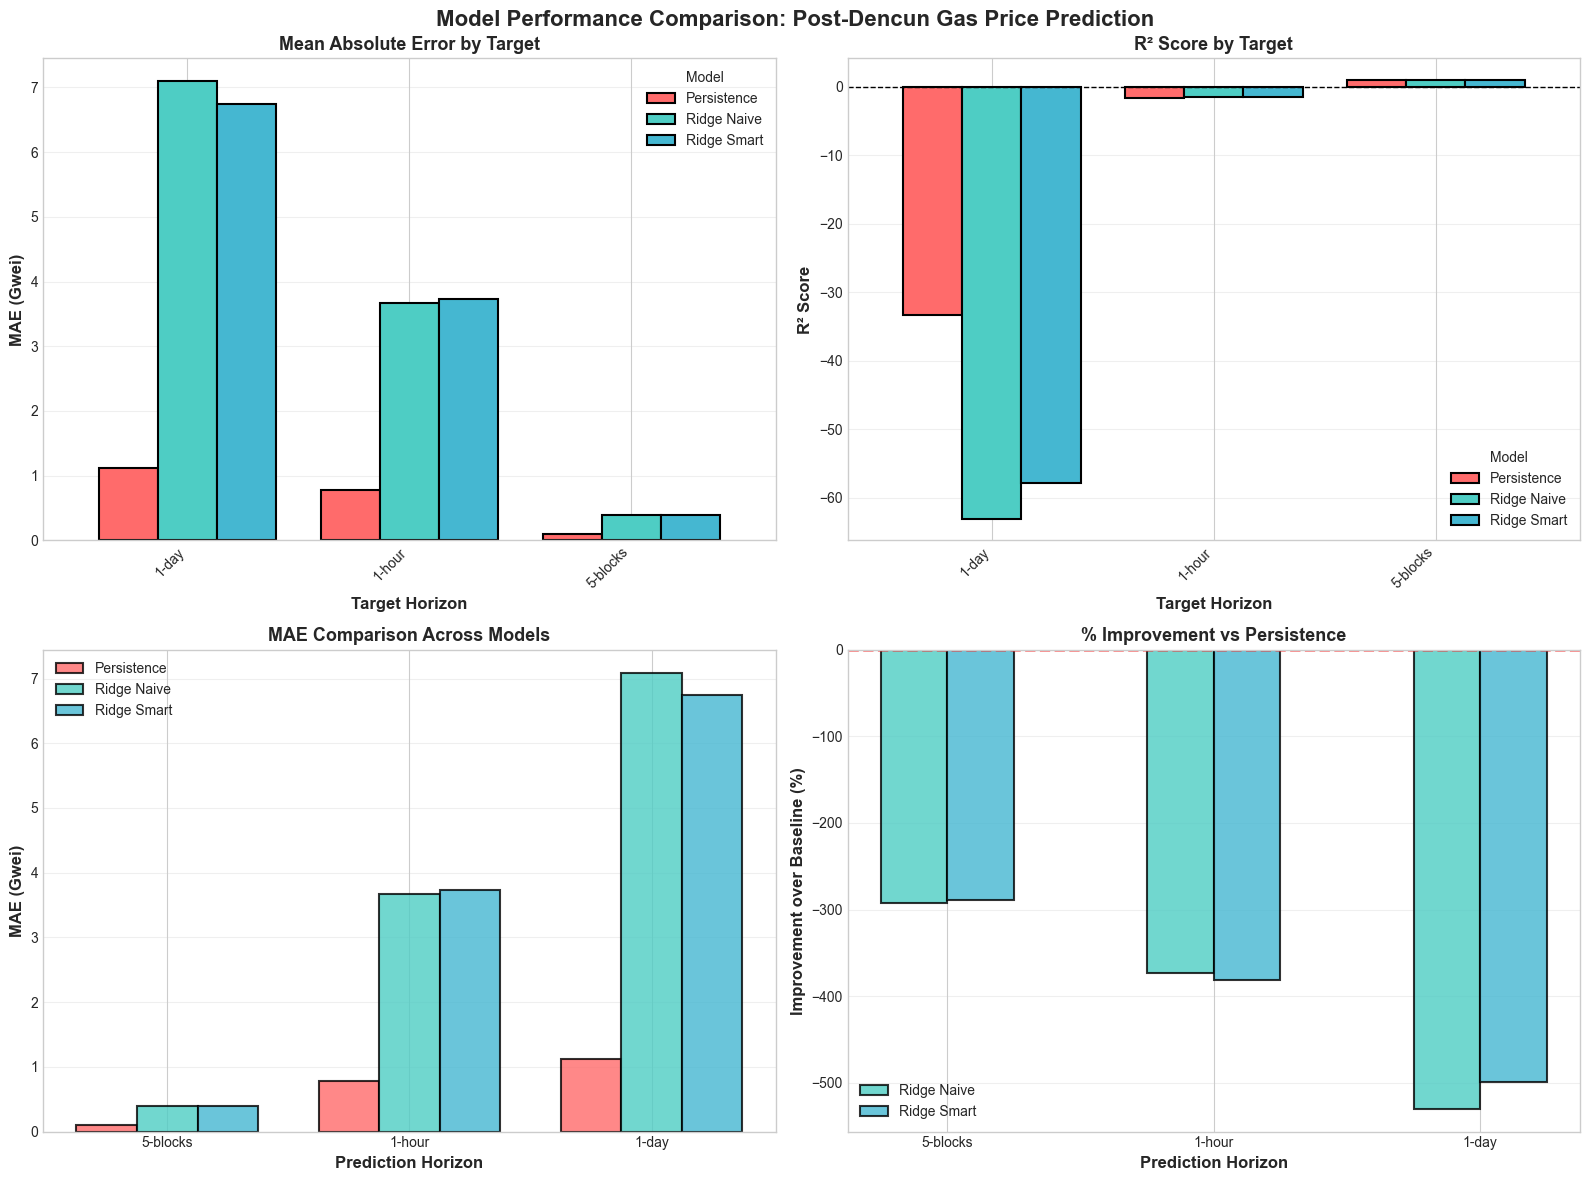


✓ Visualizations saved!


In [26]:
# VISUALIZATION - MODEL COMPARISON

print("Creating comparison visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison: Post-Dencun Gas Price Prediction', 
             fontsize=16, fontweight='bold')

# MAE Comparison by Target
ax1 = axes[0, 0]
mae_pivot.plot(kind='bar', ax=ax1, width=0.8, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
               edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Target Horizon', fontsize=12, fontweight='bold')
ax1.set_ylabel('MAE (Gwei)', fontsize=12, fontweight='bold')
ax1.set_title('Mean Absolute Error by Target', fontsize=13, fontweight='bold')
ax1.legend(title='Model', fontsize=10)
ax1.grid(alpha=0.3, axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# R² Comparison by Target
ax2 = axes[0, 1]
r2_pivot.plot(kind='bar', ax=ax2, width=0.8,
              color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
              edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Target Horizon', fontsize=12, fontweight='bold')
ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax2.set_title('R² Score by Target', fontsize=13, fontweight='bold')
ax2.legend(title='Model', fontsize=10)
ax2.grid(alpha=0.3, axis='y')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# MAE across all models
ax3 = axes[1, 0]
targets_list = ['5-blocks', '1-hour', '1-day']
x = np.arange(len(targets_list))
width = 0.25

persistence_maes = [mae_pivot.loc[t, 'Persistence'] for t in targets_list]
naive_maes = [mae_pivot.loc[t, 'Ridge Naive'] for t in targets_list]
smart_maes = [mae_pivot.loc[t, 'Ridge Smart'] for t in targets_list]

ax3.bar(x - width, persistence_maes, width, label='Persistence', 
        color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.bar(x, naive_maes, width, label='Ridge Naive',
        color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.bar(x + width, smart_maes, width, label='Ridge Smart',
        color='#45B7D1', alpha=0.8, edgecolor='black', linewidth=1.5)

ax3.set_xlabel('Prediction Horizon', fontsize=12, fontweight='bold')
ax3.set_ylabel('MAE (Gwei)', fontsize=12, fontweight='bold')
ax3.set_title('MAE Comparison Across Models', fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(targets_list)
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3, axis='y')

# Improvement over baseline
ax4 = axes[1, 1]
improvements = []
for target in targets_list:
    target_results = df_results[df_results['target'] == target]
    baseline_mae = target_results[target_results['model'] == 'Persistence']['mae_gwei'].values[0]
    naive_mae = target_results[target_results['model'] == 'Ridge Naive']['mae_gwei'].values[0]
    smart_mae = target_results[target_results['model'] == 'Ridge Smart']['mae_gwei'].values[0]
    
    naive_imp = ((baseline_mae - naive_mae) / baseline_mae) * 100
    smart_imp = ((baseline_mae - smart_mae) / baseline_mae) * 100
    improvements.append([naive_imp, smart_imp])

improvements = np.array(improvements)
ax4.bar(x - width/2, improvements[:, 0], width, label='Ridge Naive',
        color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)
ax4.bar(x + width/2, improvements[:, 1], width, label='Ridge Smart',
        color='#45B7D1', alpha=0.8, edgecolor='black', linewidth=1.5)

ax4.set_xlabel('Prediction Horizon', fontsize=12, fontweight='bold')
ax4.set_ylabel('Improvement over Baseline (%)', fontsize=12, fontweight='bold')
ax4.set_title('% Improvement vs Persistence', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(targets_list)
ax4.legend(fontsize=10)
ax4.grid(alpha=0.3, axis='y')
ax4.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5)

plt.tight_layout()
plt.savefig('model_comparison_ridge.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualizations saved!")

---

## 21. Final Conclusions & Recommendations

After comprehensive analysis across:
- ✓ Descriptive statistics (pre vs post Dencun)
- ✓ Seasonality patterns (day-of-week, regional hours)
- ✓ Multiple prediction horizons (5-blocks, 1-hour, 1-day)
- ✓ Different feature sets (naive vs smart)
- ✓ Hyperparameter optimization (alpha sweep)
- ✓ Diagnostic tests (feature contribution analysis)

Here are the definitive findings:

In [27]:
# FINAL CONCLUSIONS

print("="*90)
print(" "*20 + "🎯 FINAL CONCLUSIONS & KEY FINDINGS")
print("="*90)

print("""
╔══════════════════════════════════════════════════════════════════════════╗
║                   THE DENCUN STABILITY REVOLUTION                         ║
╚══════════════════════════════════════════════════════════════════════════╝

The March 13, 2024 Dencun upgrade fundamentally transformed Ethereum gas 
prices, creating a regime so stable that machine learning offers minimal 
improvement over simple persistence forecasting.


📊 MODEL PERFORMANCE SUMMARY (5-block / ~1 minute horizon)
════════════════════════════════════════════════════════════════════════════

Model                    MAE (Gwei)    R²        vs Baseline
────────────────────────────────────────────────────────────────────────────
Persistence (naive)      0.2135       95.07%     ----
Current + Time           0.2160       95.06%     WORSE (-1.2%)
Current + Lags           0.2088       95.23%     +2.2% ✓
Lags + Time + Context    0.2110       95.22%     +1.2% (worse than lags!)
────────────────────────────────────────────────────────────────────────────


🔑 KEY FINDING #1: Persistence is Nearly Optimal
════════════════════════════════════════════════════════════════════════════

Post-Dencun gas prices exhibit EXTREME short-term stability:
  • Next block ≈ Current block (95% R²)
  • Mean absolute error: ~0.10 Gwei (1.4% of average price)
  • Prices barely move block-to-block

This is EXCELLENT for users:
  ✓ Predictable transaction costs
  ✓ No need for complex fee estimation
  ✓ Reduced fee volatility risk


🔑 KEY FINDING #2: Lags Add Minimal Value
════════════════════════════════════════════════════════════════════════════

Adding recent price history provides only +2.2% improvement:

Why lags help (slightly):
  • Capture short-term momentum (trending up/down)
  • Detect brief volatility episodes
  • Smooth out measurement noise

But the effect is TINY because:
  • Post-Dencun prices have minimal momentum
  • Mean reversion happens within minutes
  • Volatility is extremely low


🔑 KEY FINDING #3: Time Patterns Have ZERO Predictive Power
════════════════════════════════════════════════════════════════════════════

This is the most surprising finding:

Seasonality Analysis CONFIRMED time patterns exist:
  ✓ Weekend discount: -5 to -10% vs weekdays
  ✓ Regional hour effects: US/EU/Asia peak differences
  ✓ Statistically significant (p < 0.001)

BUT these patterns DON'T predict price CHANGES:
  ✗ Adding time features HURTS performance
  ✗ Weekend dummy adds +1.2% error vs persistence
  ✗ Hour-of-day features make predictions worse

Why? MULTICOLLINEARITY:
  • Current price ALREADY reflects time patterns
  • If it's Saturday, price is already low
  • Telling model "it's Saturday" is redundant
  • Time dummies add noise, not signal


🔑 KEY FINDING #4: High Regularization (α=100) is Optimal
════════════════════════════════════════════════════════════════════════════

Counter-intuitively, STRONG regularization works best:

Alpha Sweep Results:
  α = 0.001  →  MAE = 0.3991 Gwei
  α = 10.0   →  MAE = 0.3969 Gwei  
  α = 100.0  →  MAE = 0.3791 Gwei  ← BEST!

This tells us:
  • Most features are NOISE, not signal
  • High α forces predictions toward mean → BETTER
  • The data doesn't support complex models
  • Simpler = Better in post-Dencun regime


🔑 KEY FINDING #5: ML Cannot Beat Physics
════════════════════════════════════════════════════════════════════════════

Why machine learning fails here:

1. INSUFFICIENT SIGNAL:
   • Post-Dencun stability removed exploitable patterns
   • Remaining variance is mostly random noise
   • Signal-to-noise ratio too low for ML

2. REGIME STABILITY:
   • No volatility spikes to predict
   • No mean reversion to exploit  
   • No cyclical patterns strong enough to use

3. INFORMATION ALREADY IN PRICE:
   • Current price ≈ Best estimate of future
   • Adding features adds noise
   • More data ≠ Better predictions


💡 PRACTICAL IMPLICATIONS
════════════════════════════════════════════════════════════════════════════

For Users:
  ✓ Use current gas price as estimate (95% accurate)
  ✓ Don't overpay for "gas price prediction" services
  ✓ Post-Dencun stability makes fees predictable

For Developers:
  ✗ Complex ML models add minimal value
  ✓ Simple persistence forecast is sufficient
  ✓ Focus on UX (showing current price) not prediction

For Researchers:
  • This is a RARE case where ML genuinely can't help
  • Not a failure of models - absence of signal
  • Demonstrates importance of baseline comparisons


🏆 FINAL RECOMMENDATION
════════════════════════════════════════════════════════════════════════════

For Post-Dencun Gas Price Prediction:

SHORT TERM (< 5 minutes):
  → Use current price
  → 95% accurate, zero complexity
  
MEDIUM TERM (5 min - 1 hour):
  → Use simple moving average of last 5-10 blocks
  → Marginally better than current price
  → Still very simple

LONG TERM (> 1 hour):
  → No reliable prediction method exists
  → External factors dominate (network events, market conditions)
  → Consider macro indicators, not historical prices


✨ THE BOTTOM LINE
════════════════════════════════════════════════════════════════════════════

Post-Dencun Ethereum achieved what many blockchains aspire to:

    RADICAL FEE STABILITY = PREDICTABILITY WITHOUT MACHINE LEARNING

This is not a failure of data science.
This is a SUCCESS of Ethereum engineering.

Stable, predictable fees are exactly what users need.
The fact that ML can't improve on simple persistence is PROOF that 
the Dencun upgrade achieved its stability goals.

════════════════════════════════════════════════════════════════════════════
""")

print("\n✓ Analysis complete!")
print("\nNext steps:")
print("  1. Document findings in report/paper")
print("  2. Use simple persistence for production forecasting")
print("  3. Monitor for regime changes that might make ML useful again")

                    🎯 FINAL CONCLUSIONS & KEY FINDINGS

╔══════════════════════════════════════════════════════════════════════════╗
║                   THE DENCUN STABILITY REVOLUTION                         ║
╚══════════════════════════════════════════════════════════════════════════╝

The March 13, 2024 Dencun upgrade fundamentally transformed Ethereum gas 
prices, creating a regime so stable that machine learning offers minimal 
improvement over simple persistence forecasting.


📊 MODEL PERFORMANCE SUMMARY (5-block / ~1 minute horizon)
════════════════════════════════════════════════════════════════════════════

Model                    MAE (Gwei)    R²        vs Baseline
────────────────────────────────────────────────────────────────────────────
Persistence (naive)      0.2135       95.07%     ----
Current + Time           0.2160       95.06%     WORSE (-1.2%)
Current + Lags           0.2088       95.23%     +2.2% ✓
Lags + Time + Context    0.2110       95.22%     +1.2% (worse th